# Tracking Origins

_Brief abstract/introduction/motivation.  State what the chapter is about in 1-2 paragraphs._
_Then, have an introduction video:_

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Slicer import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:



## Approach 1: Wrap Data

In [3]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In [4]:
m = middle(2, 1, 3)
m

1

In [5]:
import inspect

## Instrumenting Assignments

In [6]:
import ast
import astor

In [7]:
from bookutils import rich_output

In [8]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

In [9]:
import math

In [10]:
def square_root(x):
    assert x >= 0  # precondition

    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2

    assert math.isclose(approx * approx, x)
    return approx

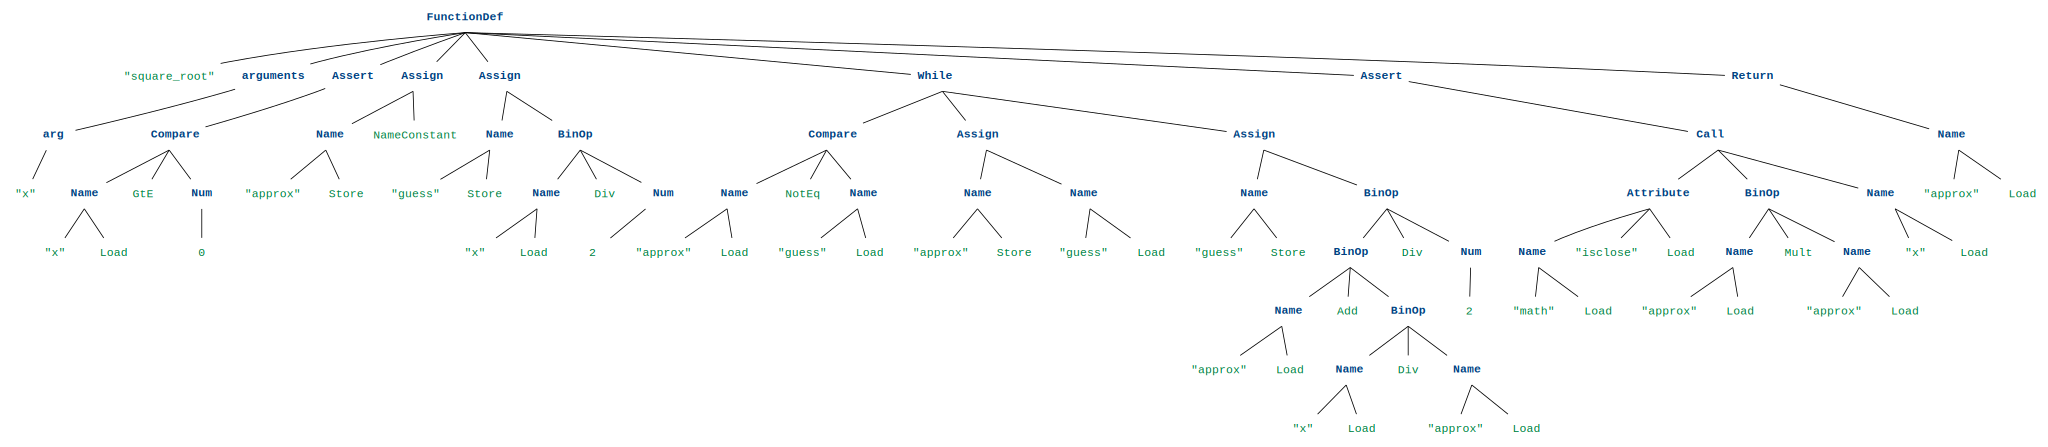

In [11]:
square_root_tree = ast.parse(inspect.getsource(square_root))
show_ast(square_root_tree)

In [12]:
from ast import NodeTransformer, Subscript, Constant, Name, Load, Store, \
    Assign, Attribute, If, With, withitem, Return, Index, Str

In [13]:
DATA_STORE = '_data'

In [14]:
print(ast.dump(ast.parse(f"{DATA_STORE}['x']")))

Module(body=[Expr(value=Subscript(value=Name(id='_data', ctx=Load()), slice=Index(value=Str(s='x')), ctx=Load()))])


In [15]:
def make_data_access(id, ctx):
    return Subscript(
        value=Name(id=DATA_STORE, ctx=Load()),
        slice=Index(value=Str(s=id)),
        ctx=ctx
    )

In [16]:
class AccessTransformer(NodeTransformer):
    def visit_Name(self, node):
        return make_data_access(node.id, node.ctx)

In [17]:
new_square_root_tree = AccessTransformer().visit(square_root_tree)
print(astor.to_source(new_square_root_tree))

def square_root(x):
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data['approx'] != _data['guess']:
        _data['approx'] = _data['guess']
        _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']) / 2
    assert _data['math'].isclose(_data['approx'] * _data['approx'], _data['x'])
    return _data['approx']



In [18]:
class SaveArgsTransformer(NodeTransformer):
    def visit_FunctionDef(self, node):
        named_args = []
        for child in ast.iter_child_nodes(node.args):
            if isinstance(child, ast.arg):
                named_args.append(child.arg)

        assign_stmts = []
        for arg in named_args:
            assign_stmt = Assign(
                targets=[make_data_access(arg, Store())],
                value=Name(id=arg, ctx=Load())
            )
            assign_stmts.append(assign_stmt)

        node.body = assign_stmts + node.body
        return node

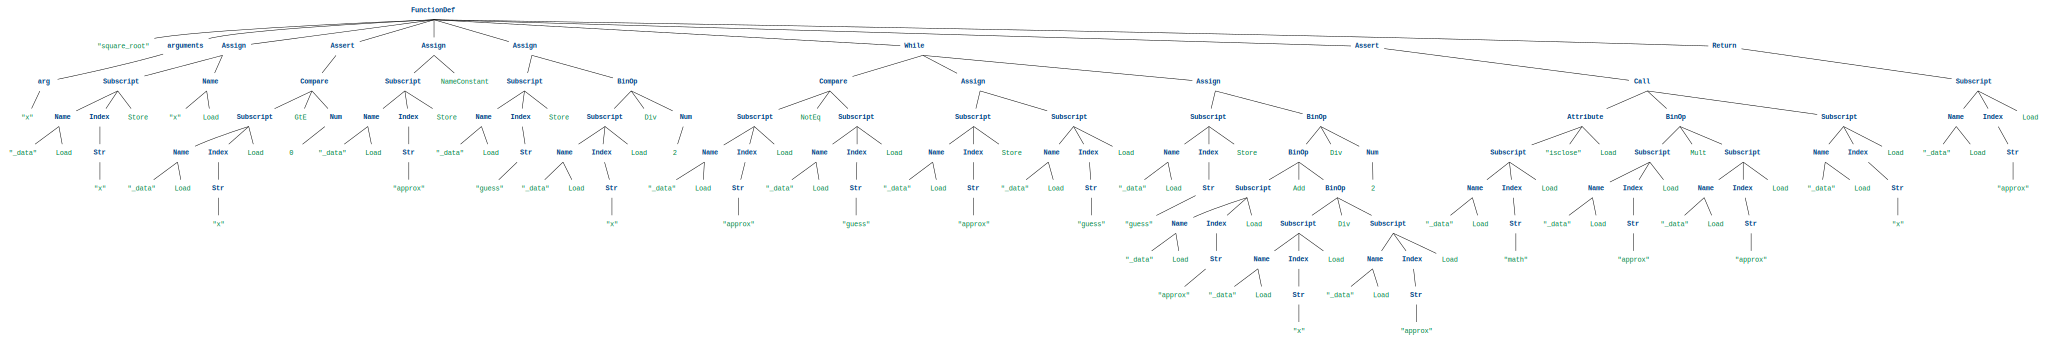

In [19]:
new_square_root_tree = SaveArgsTransformer().visit(new_square_root_tree)
show_ast(new_square_root_tree)

In [20]:
print(astor.to_source(new_square_root_tree))

def square_root(x):
    _data['x'] = x
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data['approx'] != _data['guess']:
        _data['approx'] = _data['guess']
        _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']) / 2
    assert _data['math'].isclose(_data['approx'] * _data['approx'], _data['x'])
    return _data['approx']



In [21]:
class SaveReturnTransformer(NodeTransformer):
    RETURN_VALUE = '<return value>'

    def visit_Return(self, node):
        assign_node = Assign(
                targets=[make_data_access(self.RETURN_VALUE, Store())],
                value=node.value
            )
        return_node = Return(
                value=make_data_access(self.RETURN_VALUE, Load())
            )
        ast.copy_location(assign_node, node)
        ast.copy_location(return_node, node)

        return [
            assign_node,
            return_node
        ]

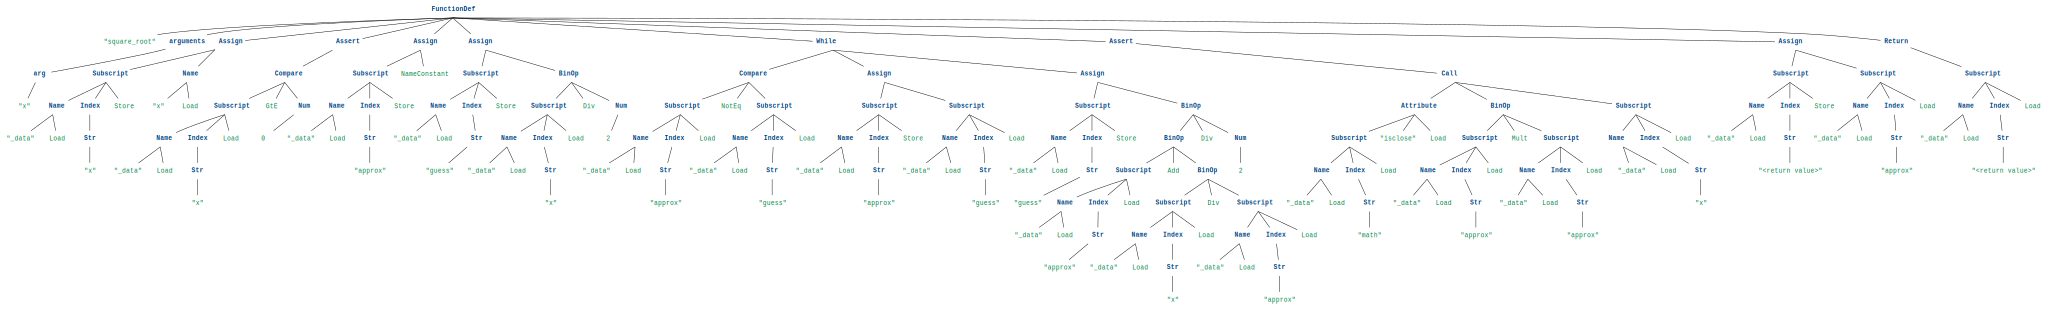

In [22]:
new_square_root_tree = SaveReturnTransformer().visit(new_square_root_tree)
show_ast(new_square_root_tree)

In [23]:
print(astor.to_source(new_square_root_tree))

def square_root(x):
    _data['x'] = x
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data['approx'] != _data['guess']:
        _data['approx'] = _data['guess']
        _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']) / 2
    assert _data['math'].isclose(_data['approx'] * _data['approx'], _data['x'])
    _data['<return value>'] = _data['approx']
    return _data['<return value>']



In [24]:
class ControlTransformer(NodeTransformer):
    def make_with(self, block):
        if len(block) == 0:
            return []

        return [With(
            items=[
                withitem(
                    context_expr=Name(id=DATA_STORE, ctx=Load()),
                    optional_vars=None)
            ],
            body=block
        )]

    def visit_If(self, node):
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return self.generic_visit(node)

    def visit_While(self, node):
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return self.generic_visit(node)

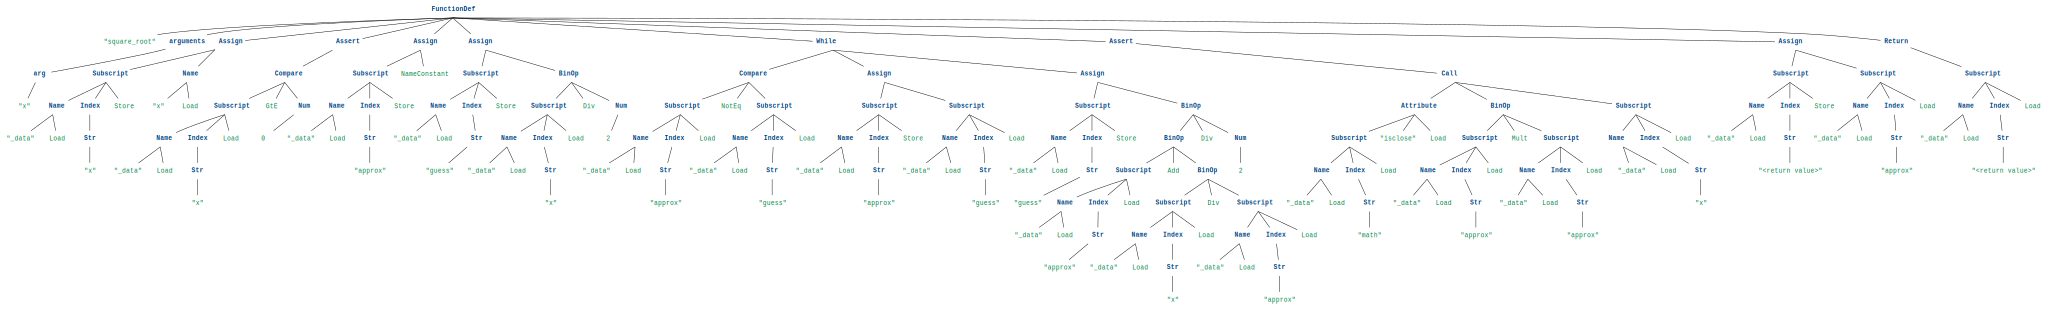

In [25]:
show_ast(new_square_root_tree)

In [26]:
print(astor.to_source(new_square_root_tree))

def square_root(x):
    _data['x'] = x
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data['approx'] != _data['guess']:
        _data['approx'] = _data['guess']
        _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']) / 2
    assert _data['math'].isclose(_data['approx'] * _data['approx'], _data['x'])
    _data['<return value>'] = _data['approx']
    return _data['<return value>']



In [27]:
def print_ast_ids(tree):
    for node in ast.walk(tree):
        print(node)
        try:
            print(astor.to_source(node))
        except AttributeError:
            print("(No source)\n")

In [28]:
# print_ast_ids(new_square_root_tree)

In [29]:
class DataStore(dict):
    def __init__(self, *args):
        super().__init__(*args)

    def __getitem__(self, name):
        if name in self:
            return super().__getitem__(name)
        else:
            return globals()[name]

    def __setitem__(self, name, value):
        return super().__setitem__(name, value)

    def __repr__(self):
        return super().__repr__()

    def __enter__(self):
        pass

    def __exit__(self, exc_type, exc_value, traceback):
        pass

In [30]:
class DataLogger(DataStore):
    def caller_location(self):
        frame = inspect.currentframe().f_back.f_back
        return f"{frame.f_code.co_name}:{frame.f_lineno}"

    def __getitem__(self, name):
        print(self.caller_location(), "reading", name)
        return super().__getitem__(name)

    def __setitem__(self, name, value):
        print(self.caller_location(), "storing", name)
        return super().__setitem__(name, value)

In [31]:
import itertools

In [32]:
class DataTracker(DataStore):
    def __init__(self, *args):
        super().__init__(*args)
        self.origins = {}
        self.data_dependencies = {}
        self.control_dependencies = {}
        self.last_read = []
        self.last_read_location = None
        self.control = [[]]

    def caller_location(self):
        frame = inspect.currentframe().f_back.f_back
        return (frame.f_code.co_name, frame.f_lineno)

    def __getitem__(self, name):
        location = self.caller_location()
        if location != self.last_read_location:
            self.last_read_location = location
            self.last_read = []
        self.last_read.append(name)
        return super().__getitem__(name)

    def __setitem__(self, name, value):
        location = self.caller_location()

        new_data_dependencies = self.data_dependencies[(name, location)] \
            if (name, location) in self.data_dependencies else set()

        for var_read in self.last_read:
            if var_read in self.origins:
                new_data_dependencies.add((var_read, self.origins[var_read]))

        new_control_dependencies = self.control_dependencies[(name, location)] \
            if (name, location) in self.control_dependencies else set()

        for var_read in itertools.chain.from_iterable(self.control):
            if var_read in self.origins:
                new_control_dependencies.add((var_read, self.origins[var_read]))

        self.data_dependencies[(name, location)] = new_data_dependencies
        self.control_dependencies[(name, location)] = new_control_dependencies

        self.origins[name] = location

        return super().__setitem__(name, value)

    def __enter__(self):
        self.control.append(self.last_read)

    def __exit__(self, exc_type, exc_value, traceback):
        self.control.pop()

In [33]:
class Instrumenter(object):
    def __init__(self, *items_to_instrument, log=False):
        self.log = log
        self.items_to_instrument = items_to_instrument

    def __enter__(self):
        """Instrument sources"""
        for item in self.items_to_instrument:
            self.instrument(item)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Restore sources"""
        self.restore()
        
    def restore(self):
        for item in self.items_to_instrument:
            globals()[item.__name__] = item

    def instrument(self, item):
        if self.log:
            print("Instrumenting", item)

In [34]:
with Instrumenter(square_root) as ins:
    pass

In [35]:
class Slicer(Instrumenter):
    def instrument(self, item):
        source_lines, lineno = inspect.getsourcelines(item)
        tree = ast.parse("".join(source_lines))
        ast.increment_lineno(tree, lineno - 1)

        AccessTransformer().visit(tree)
        SaveArgsTransformer().visit(tree)
        SaveReturnTransformer().visit(tree)
        ControlTransformer().visit(tree)
        
        ast.fix_missing_locations(tree)
        # print_ast_ids(tree)

        if self.log:
            print(f"Instrumenting {item}:")
            print(astor.to_source(tree))

        code = compile(tree, '<string>', 'exec')
        exec(code, globals())
        globals()[DATA_STORE] = DataTracker()
        
    def restore(self):
        self.data_store = globals()[DATA_STORE]
        del globals()[DATA_STORE]
        super().restore()

    def data_dependencies(self):
        return self.data_store.data_dependencies

    def control_dependencies(self):
        return self.data_store.control_dependencies

In [36]:
with Slicer(square_root, log=True) as slicer:
    y = square_root(9)
y

Instrumenting <function square_root at 0x7ff595b5a378>:
def square_root(x):
    _data['x'] = x
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data['approx'] != _data['guess']:
        with _data:
            _data['approx'] = _data['guess']
            _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']
                ) / 2
    assert _data['math'].isclose(_data['approx'] * _data['approx'], _data['x'])
    _data['<return value>'] = _data['approx']
    return _data['<return value>']



3.0

In [37]:
slicer.data_dependencies()

{('x', ('square_root', 1)): set(),
 ('approx', ('square_root', 4)): {('x', ('square_root', 1))},
 ('guess', ('square_root', 5)): {('x', ('square_root', 1))},
 ('approx', ('square_root', 7)): {('guess', ('square_root', 5)),
  ('guess', ('square_root', 8))},
 ('guess', ('square_root', 8)): {('approx', ('square_root', 7)),
  ('x', ('square_root', 1))},
 ('<return value>', ('square_root', 11)): {('approx', ('square_root', 7))}}

In [38]:
slicer.control_dependencies()

{('x', ('square_root', 1)): set(),
 ('approx', ('square_root', 4)): set(),
 ('guess', ('square_root', 5)): set(),
 ('approx', ('square_root', 7)): {('approx', ('square_root', 4)),
  ('approx', ('square_root', 7)),
  ('guess', ('square_root', 5)),
  ('guess', ('square_root', 8))},
 ('guess', ('square_root', 8)): {('approx', ('square_root', 7)),
  ('guess', ('square_root', 5)),
  ('guess', ('square_root', 8))},
 ('<return value>', ('square_root', 11)): set()}

In [39]:
square_root(9)

3.0

In [40]:
from graphviz import Digraph, nohtml

In [41]:
import html

In [42]:
# ignore
STEP_COLOR = 'peachpuff'
FONT_NAME = 'Fira Mono'

In [43]:
# ignore
def graph(comment="default"):
    return Digraph(name='', comment=comment, 
        graph_attr={
        },
        node_attr={
            'style': 'filled',
            'shape': 'box',
            'fillcolor': STEP_COLOR,
            'fontname': FONT_NAME
        },
        edge_attr={
            'fontname': FONT_NAME
        })

In [44]:
# ignore
def display_dependencies(data_dependencies, control_dependencies={}):
    def id(node):
        return html.escape(repr(node))

    def label(node):
        (name, location) = node
        code_name, lineno = location
        fun = globals()[code_name]
        source_lines, first_lineno = inspect.getsourcelines(fun)
        source = source_lines[lineno - first_lineno].strip()
        
        return (f'<' +
            f'<B><I>{html.escape(name)}</I></B>' +
            f'<FONT POINT-SIZE="9.0"><BR/><BR/>{source}</FONT>' +
            '>')
    
    def tooltip(node):
        (name, location) = node
        code_name, lineno = location
        return f"{code_name}:{lineno}"

    # Draw dependencies
    g = graph()
    all_nodes = set()
    for node in data_dependencies:
        g.node(id(node), label=label(node), tooltip=tooltip(node))
        all_nodes.add(node)

        for source in data_dependencies[node]:
            g.edge(id(source), id(node))
            all_nodes.add(source)

        for source in control_dependencies[node]:
            g.edge(id(source), id(node), style='dashed', color='grey')
            all_nodes.add(source)
            
    # Add invisible edges for those nodes in the same location
    code_names = {}
    for node in all_nodes:
        (name, location) = node
        code_name, lineno = location
        if code_name not in code_names:
            code_names[code_name] = []
        code_names[code_name].append((lineno, node))
        
    for code_name in code_names:
        code_names[code_name].sort()

    for code_name in code_names:
        last_node = None
        last_lineno = 0
        for (lineno, node) in code_names[code_name]:
            if last_node is not None and lineno > last_lineno:
                g.edge(id(last_node), id(node), style='invis',)
            last_node = node
            last_lineno = lineno

    return g

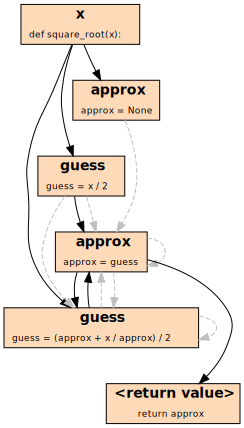

In [45]:
display_dependencies(slicer.data_dependencies(),
                     slicer.control_dependencies()
                    )

In [46]:
with Slicer(middle, log=True) as middle_slicer:
    y = middle(2, 1, 3)

Instrumenting <function middle at 0x7ff595b12e18>:
def middle(x, y, z):
    _data['x'] = x
    _data['y'] = y
    _data['z'] = z
    if _data['y'] < _data['z']:
        with _data:
            if _data['x'] < _data['y']:
                with _data:
                    _data['<return value>'] = _data['y']
                    return _data['<return value>']
            else:
                with _data:
                    if _data['x'] < _data['z']:
                        with _data:
                            _data['<return value>'] = _data['y']
                            return _data['<return value>']
    else:
        with _data:
            if _data['x'] > _data['y']:
                with _data:
                    _data['<return value>'] = _data['y']
                    return _data['<return value>']
            else:
                with _data:
                    if _data['x'] > _data['z']:
                        with _data:
                            _data['<return value>'] =

In [47]:
middle_slicer.control_dependencies()

{('x', ('middle', 1)): set(),
 ('y', ('middle', 1)): set(),
 ('z', ('middle', 1)): set(),
 ('<return value>', ('middle', 6)): {('x', ('middle', 1)),
  ('y', ('middle', 1)),
  ('z', ('middle', 1))}}

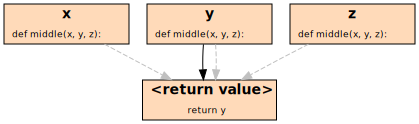

In [48]:
display_dependencies(middle_slicer.data_dependencies(),
                     middle_slicer.control_dependencies()
                    )

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

You can use `int_fuzzer()` as:

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

@INPROCEEDINGS{6899220,
  author={Z. {Chen} and L. {Chen} and Y. {Zhou} and Z. {Xu} and W. C. {Chu} and B. {Xu}},
  booktitle={2014 IEEE 38th Annual Computer Software and Applications Conference}, 
  title={Dynamic Slicing of Python Programs}, 
  year={2014},
  volume={},
  number={},
  pages={219-228},
  doi={10.1109/COMPSAC.2014.30}
}



## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [49]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [50]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_

In [51]:
import traceback

In [52]:
class tint(int):
    def __new__(cls, value, *args, **kw):
        return int.__new__(cls, value)

    def __init__(self, value, slice=None, **kwargs):
        self.slice = [self.current_location()]
        if slice is not None:
            self.slice += slice

    def current_location(self):
        frame = inspect.currentframe()
        while ('self' in frame.f_locals and 
               isinstance(frame.f_locals['self'], tint)):
            frame = frame.f_back

        return (frame.f_code.co_name, frame.f_lineno)

In [53]:
class tint(tint):
    def __repr__(self):
        return int.__repr__(self)

In [54]:
class tint(tint):
    def __str__(self):
        return int.__str__(self)

In [55]:
x = tint(2)
x

2

In [56]:
x.slice

[('<module>', 1)]

In [57]:
x == 2

True

In [58]:
type(x)

__main__.tint

In [59]:
class tint(tint):
    def create(self, x):
        return tint(x, slice=self.slice)

Operators are defined in the [Python data model](https://docs.python.org/3/reference/datamodel.html)

In [60]:
class tint(tint):
    def __add__(self, x):
        return self.create(int(self) + x)
    def __radd__(self, x):
        return self.create(x + int(self))

In [61]:
x = tint(2)
x = x + 2
type(x)

__main__.tint

In [62]:
x

4

In [63]:
class tint(tint):
    def __sub__(self, x):
        return self.create(int(self) - x)
    def __rsub__(self, x):
        return self.create(x - int(self))

In [64]:
class tint(tint):
    def __mul__(self, x):
        return self.create(int(self) * x)
    def __rmul__(self, x):
        return self.create(x * int(self))

In [65]:
class tint(tint):
    def __matmul__(self, x):
        return self.create(int(self) @ x)
    def __rmatmul__(self, x):
        return self.create(x @ int(self))

In [66]:
class tint(tint):
    def __truediv__(self, x):
        return self.create(int(self) / x)
    def __rtruediv__(self, x):
        return self.create(x / int(self))

In [67]:
class tint(tint):
    def __floordiv__(self, x):
        return self.create(int(self) // x)
    def __rfloordiv__(self, x):
        return self.create(x // int(self))

In [68]:
class tint(tint):
    def __mod__(self, x):
        return self.create(int(self) % x)
    def __rmod__(self, x):
        return self.create(x % int(self))

In [69]:
class tint(tint):
    def __divmod__(self, x):
        return self.create(divmod(int(self), x))
    def __rdivmod__(self, x):
        return self.create(divmod(x, int(self)))

In [70]:
class tint(tint):
    def __pow__(self, x):
        return self.create(int(self) ** x)
    def __rpow__(self, x):
        return self.create(x ** int(self))

In [71]:
class tint(tint):
    def __lshift__(self, x):
        return self.create(int(self) << x)
    def __rlshift__(self, x):
        return self.create(x << int(self))

In [72]:
class tint(tint):
    def __rshift__(self, x):
        return self.create(int(self) >> x)
    def __rrshift__(self, x):
        return self.create(x >> int(self))

In [73]:
class tint(tint):
    def __and__(self, x):
        return self.create(int(self) & x)
    def __rand__(self, x):
        return self.create(x & int(self))

In [74]:
class tint(tint):
    def __xor__(self, x):
        return self.create(int(self) ^ x)
    def __rxor__(self, x):
        return self.create(x ^ int(self))

In [75]:
class tint(tint):
    def __or__(self, x):
        return self.create(int(self) | x)
    def __ror__(self, x):
        return self.create(x | int(self))

In [76]:
class tint(tint):
    def __neg__(self):
        return self.create(-int(self))
    def __pos__(self):
        return self.create(+int(self))
    def __abs__(self):
        return self.create(abs(int(self)))
    def __invert__(self):
        return self.create(-int(self))

In [77]:
class tint(tint):
    def __index__(self):
        return int(self)

In [78]:
x = tint(2)
y = x + 3 - (3 + x)

In [79]:
y, type(y), y.slice

(0, __main__.tint, [('<module>', 2), ('<module>', 2), ('<module>', 1)])

In [80]:
x = tint(2)
y = tint(1)
z = tint(3)
m = middle(x, y, z)
m, m.slice

(1, [('<module>', 2)])

In [81]:
x = tint(4)
y = square_root(x)

In [82]:
y.slice

[('square_root', 5), ('<module>', 1)]

In [83]:
from ExpectError import ExpectError

In [84]:
with ExpectError():
    y = square_root(tint(2))

Traceback (most recent call last):
  File "<ipython-input-84-e37ffc83d5d9>", line 2, in <module>
    y = square_root(tint(2))
  File "<ipython-input-10-9c2f33817d60>", line 10, in square_root
    assert math.isclose(approx * approx, x)
AssertionError (expected)


Next steps:

* implement `tfloat`
* instrument assignments

```python
with Slicer() as slicer:
    x = foobar(blue)
slicer
```
x was initialized from ...
blue was just there :-)